<a href="https://colab.research.google.com/github/ShineySun/BASIC_AI/blob/master/AI_Study2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#인공지능 study 2
## 20143038 김선필
###### 1. [영상 인식] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
is_cuda = False
# gpu 사용 여부 검사
if torch.cuda.is_available():
  is_cuda = True

# Mnist 데이터를 정규화 (각 채널별)
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = datasets.MNIST('data/',train = True, transform = transformation, download = True)
test_dataset = datasets.MNIST('data/',train = False, transform = transformation, download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)
# sample_data -> train_loader의 시작 데이터
sample_data = next(iter(train_loader))

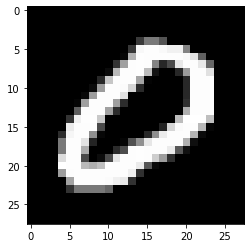

In [0]:
# plot_img : 평균과 표준편차를 이용하여 이미지를 정규화 시키고 출력한다.
def plot_img(image):
  image = image.numpy()[0]
  mean = 0.1307
  std = 0.3081
  image = ((mean*image) + std)
  plt.imshow(image, cmap = 'gray')

# 화면 출력 확인
plot_img(sample_data[0][2]) 

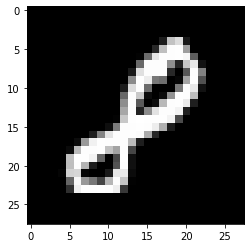

In [0]:
# 화면 출력 확인
plot_img(sample_data[0][1])

In [0]:
# class definition
class Net(nn.Module):
  # 클래스 생성자
  def __init__(self):
    super().__init__()
    # input : 1  output : 10  kernel : 5x5
    self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
    # input : 10  output : 20  kernel : 5x5
    self.conv2 = nn.Conv2d(10,20,kernel_size = 5)
    # Dropout : 생성된 특징맵에서 필요한 것들만 보겠다. - overfitting 해결
    # 디폴트 값의 확률의 드롭아웃을 만든다.
    self.conv2_drop = nn.Dropout2d()

    # 선형 완전 연결층
    # input : 320  output : 50
    self.fc1 = nn.Linear(320,50)
    # input : 50   output : 10
    self.fc2 = nn.Linear(50,10)
  
  # 순전파
  def forward(self,x):
    # conv1 층 통과후 max pooling 하여 활성함수 relu를 통과 시킨다.
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    # conv2 을 통과 후 드랍 아웃을 시킨다.
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1,320)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    # log softmax 함수를 통과 시킨 x 값을 반환한다.
    return F.log_softmax(x,dim=1)

model = Net()

if is_cuda:
  model.cuda()

# 스토캐스틱 그레디언트 디센트 방법으로 최적화를 시킨다.
# 학습률은 0.01 로 정해줬다.
optimizer = optim.SGD(model.parameters(),lr = 0.01)

data, target = next(iter(train_loader))
# data를 모델에 통과 시킨다.
output = model(Variable(data.cuda()))

# output.size() 출력 확인
print(output.size())

# target.size() 출력 확인
print(target.size())


torch.Size([32, 10])
torch.Size([32])


In [0]:
# loss 와 accuracy를 계산하여 반환하는 함수
def fit(epoch, model, data_loader, phase = 'training', volatile = False):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.eval()
    volatile = True
  
  running_loss = 0.0
  running_correct = 0

  for batch_idx, (data,target) in enumerate(data_loader):
    if is_cuda:
      data,target = data.cuda(),target.cuda()
    data.target = Variable(data,volatile),Variable(target)
    # training phase에 그레디언트값을 0으로 초기화
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    # batch 사이즈마다 loss 를 구한다.
    loss = F.nll_loss(output,target)
    
    # loss를 구해서 running_loss에 더해준다.
    # running은 배치 사이즈마다 갱신이 된다.
    running_loss += F.nll_loss(output, target,size_average = False).data
    # 학습을 통해 예측을 한다.
    preds = output.data.max(dim = 1, keepdim = True)[1]
    # 예측을 한 값과 비교하여 맞을 경우 더해준다.
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()

    if phase == 'training':
      # 역전파
      loss.backward()
      # 가중치 업데이트
      optimizer.step()

  loss = running_loss/len(data_loader.dataset)
  accuracy = 100.*running_correct/len(data_loader.dataset)

  print(f"{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}")  
  return loss, accuracy


In [0]:
train_losses, train_accuracy = [],[]
val_losses, val_accuracy = [],[]
# epoch를 19세대만큼 돌린다.
for epoch in range(1,20):
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase = 'training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch,model,test_loader, phase='validation')
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.63 and training accuracy is 47958/60000     79.93
validation loss is  0.16 and validation accuracy is 9524/10000     95.24
training loss is  0.21 and training accuracy is 56408/60000     94.01
validation loss is 0.092 and validation accuracy is 9714/10000     97.14
training loss is  0.16 and training accuracy is 57245/60000     95.41
validation loss is 0.078 and validation accuracy is 9762/10000     97.62
training loss is  0.13 and training accuracy is 57662/60000      96.1
validation loss is 0.068 and validation accuracy is 9787/10000     97.87
training loss is  0.12 and training accuracy is 57867/60000     96.44
validation loss is 0.062 and validation accuracy is 9803/10000     98.03
training loss is  0.11 and training accuracy is 58110/60000     96.85
validation loss is 0.053 and validation accuracy is 9834/10000     98.34
training loss is   0.1 and training accuracy is 58220/60000     97.03
validation loss is 0.054 and validation accuracy is 9837/10000     98.37

### 학습이 진행됨에 따라 training set & validation set 의 loss 값이 줄어드는 모습을 보인다.

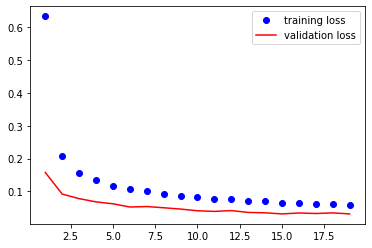

In [0]:
# training loss : blue
plt.plot(range(1,len(train_losses)+1), train_losses, 'bo', label = 'training loss')
# validation loss : red
plt.plot(range(1,len(val_losses)+1), val_losses, 'r', label = "validation loss")
plt.legend()

### 학습이 진행됨에 따라 training set & validation set 의 accuracy가 향상되는 모습을 보인다.

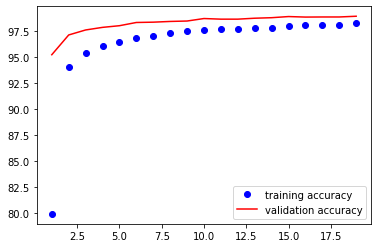

In [0]:
plt.plot(range(1,len(train_accuracy)+1), train_accuracy, 'bo', label = 'training accuracy')
plt.plot(range(1,len(val_accuracy)+1), val_accuracy, 'r', label = "validation accuracy")
plt.legend()

### [CNN] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.

##### 뉴럴 네트워크는 torch.nn 패키지를 이용하여 생성할 수 있다. 
##### autograd와 autograd를 이용하여 모델을 정의하고 미분을 수행하는 nn 패키지에 대하여 알았다. nn.Module은 여러개의 레이어와 output을 리턴하는 forward(input) 메서드를 포함한다.

#### 일반적인 뉴럴 네터워크의 학습 절차는 다음과 같다.
##### - 학습 가능한 파라미터나 weight가 있는 뉴럴 네트워크를 정의한다.
##### - 입력 데이터셋에 대한 반복 학습을 진행한다.
##### - 네트워크를 통해 입력 값을 처리한다.
##### - loss를 계산한다.
##### - 손실 계산 = 출력(output)과 정답(target)의 차이
##### - 그레디언트를 네트워크의 파라미터로 역전파(backward) 시킨다.
##### - 다음과 같이 간단한 갱신 룰을 이용하여 네트워크의 weight를 갱신한다.
##### Weight = Weight - learning_rate * gradient

In [0]:
# torch.nn 패키지를 사용하여 신경망을 생성함.
# nn 패키지는 모델을 정의할 때, autograd를 통해 자동미분 기능을 제공함
# nn.Module은 층과 전방 전파 forward propagation(입력 -> 출력)을 쉽게 구현함
# 참고로 nn 패키지는 mini-batch만 지원함, 예로 nnConv2d는 4차 Tensor를 받음(nSamples*nChannels*height*width))
# 아래 AlexNet 예시는 숫자를 분류하는 간단한 컨볼루션 신경망의 예임
# 예시는 사진 입력을 받고, 몇 개의 층에 전방 전파하면서 분류를 출력함
# - 출력을 위해서 모델은 다음과 같은 학습을 수행함.
# - 신경망은 학습가능한 매개변수(가중치들)들을 가짐
# - 사진 데이터를 반복적으로 입력함
# - 신경망을 통해 입력을 처리함 (전방 전파)
# - 손실 (오차)를 계산함  - 실제 출력과 예측 출력을 비교하여 학습의 올바름을 판단함
# - 오차로부터 그레디언트 (경사, 방향)을 신경망의 각 매개변수에게 역전파함 (오류 역전파)
# - 신경망의 매개변수들을 갱신함 ((미래)가중치 = (현재)가중치 - 학습률 * 그래디언트 )

# 위의 컨볼루션 신경망의 부분들을 torch를 통해서 손쉽게 구현할 수 있음.
# 단지 forward 함수만 정의하면, autograd를 이용해 해당 연산 그래프의 그래디언트를 구하는 backward 자동적으로 정의됨
# forward 함수는 Tensor를 이용할 수 있는 다양한 연산들을 사용하여 정의 가능함
# torch.Tensor : 자동 미분 기능을 지원하는 다차원 배열, 각 Tensor에 해당하는 그래디언트를 가짐
# nn.Module : 신경망 모듈이며 매개변수의 캡슐화, GPU 연산 등 작업을 쉽게 가능하게 함
# nn.Parameter : 모듈이 지정되면 매개변수들을 자동으로 관리하는 Tensor의 하나임


### 네트워크 정의(Define the Network)

###### 사용자는 직접 forward 함수만 정의해주면 된다. 그래디언트가 계산되는 backward 함수는 autograd를 사용함으로써 자동으로 정의 된다. 사용자는 forward 함수에서 모든 텐서 연산을 사용할 수 있다.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1,6,5)
    self.conv2 = nn.Conv2d(6,16,5)
    # an affine operation : y = Wx + b
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    # Max pooling over a (2,2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    # If the size is a square you can only specify a single number
    x = F.max_pool2d(F.relu(self.conv2(x)),2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self,x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### (2) 정의된 컨볼루션 신경망의 구조 설명

In [0]:
# net.parameters()를 사용하여 정의된 신경망의 학습가능한 매개변수들을 확인할 수 있음
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's . weight

10
torch.Size([6, 1, 5, 5])


###### 32 x 32 크기의 랜덤 값을 입력으로 사용하면 다음과 같다. 참고로 이 네트워크(LeNet)에 대한 예상 입력 크기는 32 x 32 이다. 이 네트워크를 MNIST 데이터셋을 대상으로 사용하기 위해서는 데이터셋의 이미지를 32x32 크기로 변경할 필요가 있다.

In [0]:
# 다음의 임의의 32 x 32 입력을 가정함
# 참고로 크기가 다른 입력을 받을 때는 입력의 크기를 재조정하거나 신경망을 수정함
input = torch.randn(1,1,32,32)
out = net(input)
print(out)

tensor([[ 0.0458,  0.0531,  0.0565,  0.0112,  0.0038,  0.0271, -0.0748, -0.0935,
         -0.0627,  0.0927]], grad_fn=<AddmmBackward>)


###### 모든 파라미터의 그레디언트 버퍼를 0으로 설정하고, 랜덤 그레디언트로 역전파를 진행한다.

In [0]:
# 오류 역전파를 통해 그레디언트를 구하기 전에 모든 가중치의 그레디언트 버퍼들을 초기화
net.zero_grad()
out.backward(torch.randn(1,10))

##### torch.nn 은 mini-batch만을 지원한다. 전체 torch.nn 패키지는 mini-batch 형태인 입력만을 지원하며, 단일 데이터는 입력으로 지원하지 않는다.

##### 예를 들어 nn.Conv2d 는 nSamples x nChannels x Height x Width의 4차원 텐서를 취한다.

##### 만약 단일 샘플이 있다면, input.unsqueeze(0) 을 사용하여 가짜 임시 배치 차원을 추가하면 된다.

##### 좀 더 진행하기에 앞서, 지금까지 살펴본 것을 정리하면 다음과 같다.
##### torch.Tensor - backward() 와 같은 autograd 연산을 지원하는 다차원 배열이며 텐서에 대한 그레디언트를 가지고 있다. 
##### nn.Module - 뉴럴 네트워크 모듈로서 파라미터를 GPU로 옮기거나, 내보내기, 불러오기 등의 보조 작업을 이용하여 파라미터를 캡슐화 하는 편리한 방법이다.
##### autograd.Function - autograd 연산의 forward와 backward에 대한 정의를 구현한다. 모든 Tensor 연산은 최소한 하나의 Function 노드를 생성하는데, 이 노드는 Tensor를 생성하고 기록을 인코딩 하는 여러 함수들에 연결된다.

### 손실함수 ( Loss Function )
###### 오차 함수는 (출력, 정답) 형태의 입력을 받아, 출력이 정답에서 얼마나 멀리 떨어져 있는지 추정하는 값을 계산한다.
###### nn 패키지에는 여러 가지 손실 함수들이 존재하는데 가장 간단한 loss는 nn.MSELoss로 입력과 정답 사이의 평균 제곱오차를 계산한다.

In [0]:
# 손실 함수 정의 및 임의의 값들에 대해서 오차 결과 확인
# nn 패키지는 많이 사용되는 손실함수들을 제공하며, 해당 예제는 단순한 MSE를 사용
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1,-1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.7612, grad_fn=<MseLossBackward>)


### 역전파 ( Backpropagation )
###### 에러를 역전파하기 위해 사용자는 loss.backward() 를 호출하면 된다. 다만 기존에는 그레디언트들을 초기화 할 필요가 있다. 그렇지 않으면 그레디언트들이 존재하는 그레디언트에 누적되어 저장되기 때문이다.

####### loss.backward() 를 호출하고 backward 호출 이전과 이후의 conv1's의 바이어스 그레디언트를 살펴 볼 것이다.


In [0]:
# 앞에 코드에서 언급한 것과 같이 오류 역전파하기 전, 그래디언트를 초기화해야 함
# backward() 수행 후 어떤 변화가 있는지 확인하고, 초기화의 필요성을 확인함
net.zero_grad()  # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


In [0]:
loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad after backward
tensor([ 0.0007, -0.0047,  0.0032,  0.0033, -0.0067, -0.0038])


### 가중치 갱신 ( Update the weights )
###### 실제로 사용되는 가장 간단한 갱신 룰은 SGD이며 다음과 같은 식을 가진다.
###### weight = weight - learning_rate * gradient

##### 뉴럴 네트워크를 사용할 때 SGD, Nesterov-SGD, Adam, RMSProp 등과 같은 다양한 갱신 룰을 사용하고 싶을 수도 있다. 이러한 룰의 사용을 위해 PyTorch는 위와 같은 갱신 룰을 포함하는 torch.optim 패키지를 제공한다.

In [0]:
# SGD를 이용하여 가중치 갱신하는 코드는 다음과 같음
learning_rate = 0.01
for f in net.parameters():
  f.data.sub_(f.grad.data*learning_rate)

# 하지만 위 구현 코드보다 실제, torch.optim에서 구현되는 SDG, Adam, RMSProp 등을 사용함
# 오류 역전파에서 최적화하는 방법을 보인 예제 코드
import torch.optim as optim

#create optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01)

# in training loop:
optimizer.zero_grad() # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()  # Does the update

## 3. [분류기 학습] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.

In [0]:
# 1번의 기초적인 신경망을 통해서 사진 분류기를 학습함
# 데이터집합은 CIFAR-10 이며, 아래의 예와 같이 10가지의 3 (R,G,B) 채널의 32 x 32 크기의 사진으로 구성됨.
# CIFAR-10 과 같이 많이 사용되는 데이터 집합은 torchvision 패키지에서 제공한다.


##### pytorch 에서 torchvision 이라는 패키지가 있는데, 해당 패키지는 일반적으로 사용되는 Imagenet, CIFAR10, MINIST 등과 같은 데이터셋들에 대한 데이터 로더(torchvision.datasets)와 이미지용 데이터 변환기(torch.utils.data.DataLoader)를 제공한다.

##### CIFAR -10 데이터셋은 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭 순서의 클래스들을 가지고 있다. CIFAR-10의 이미지들은 3x32x32 인데 다시 말해 픽셀 크기의 3채널 컬러 이미지이다.

#### 이미지 분류기 학습
######1. torchvision을 이용하여 CIFAR-10 의 학습(training), 평가(test) 데이터셋을 로드하여 정규화한다.
###### 2. 컨볼류션 뉴럴 네트워크를 학습 시킨다.
###### 3. 손실 함수를 정의한다.
###### 4. 학습 데이터를 이용하여 네트워크를 학습 시킨다.
###### 5. 평가 데이터셋을 이용하여 네트워크를 평가한다.

#1. CIFAR-10 로딩 및 정규화
#### torchvision을 이용하면 CIFAR-10 로딩은 손쉬운 작업.
#### torchvision 패키지의 출력은 [0,1] 범위의 PILImage 이다. 출력 데이터의 범위를 [-1,1]의 텐서로 정규화 한다,

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 deer   car  frog  ship


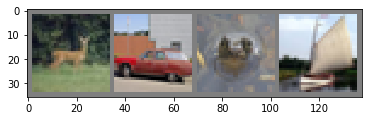

In [0]:
# 훈련집합의 일부 사진들 확인
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
  img = img/2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

# got some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. 컨볼루션 뉴럴 네트워크 (합성곱 신경망) 정의
#### 3채널 32 x 32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    # input : 3   output : 6   kernel : 5x5
    self.conv1 = nn.Conv2d(3,6,5)
    # pooling
    self.pool = nn.MaxPool2d(2,2)
    # input : 6    output : 16    kernel : 5x5
    self.conv2 = nn.Conv2d(6,16,5)
    # input : 16x5x5        output : 120
    self.fc1 = nn.Linear(16*5*5, 120)
    # input : 120          output : 84
    self.fc2 = nn.Linear(120,84)
    # input : 84          output : 10
    self.fc3 = nn.Linear(84,10)
    
  def forward(self,x) : 
    # conv1 -> relu -> pooling
    x = self.pool(F.relu(self.conv1(x)))
    # conv2 -> relu -> pool
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,16*5*5)
    # fc1 -> relu
    x = F.relu(self.fc1(x))
    # fc2 -> relu
    x = F.relu(self.fc2(x))
    # fc3
    x = self.fc3(x)
    return x

net =Net()

## 3. 손실 함수 및 Optimizer 정의
#### 손실 함수는 Classification Cross-Entropy를 사용하고, optimizer는 momentum 을 세팅한 SGD를 이용한다.

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## 4. 네트워크 학습
#### 단순히 데이터를 반복시켜 네트워크와 optimizer의 입력으로 넘겨준다.
#### 훈련 집합을 이용하여 신경망을 학습시킴.

In [0]:
for epoch in range(2): 
  # loop over the dataset multiple times
  running_loss = 0.0
  
  for i,data in enumerate(trainloader,0):
    # get the inputs
    inputs, labels = data
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()
    if (i%2000 == 1999):
      print('[%d, %5d] loss : %.3f' % (epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

print("Finished Training")  

[1,  2000] loss : 2.168
[1,  4000] loss : 1.834
[1,  6000] loss : 1.653
[1,  8000] loss : 1.575
[1, 10000] loss : 1.515
[1, 12000] loss : 1.470
[2,  2000] loss : 1.427
[2,  4000] loss : 1.393
[2,  6000] loss : 1.355
[2,  8000] loss : 1.316
[2, 10000] loss : 1.294
[2, 12000] loss : 1.308
Finished Training


### (3) 화면 출력 확인 및 학습이 되고 있는지 서술
#### 위의 결과를 보면 두번의 epoch 를 돌면서 학습을 시켰다. 두 세대에서 모두 loss 값이 줄어드는 경황을 봤을 때, 학습이 되고 있다 할 수 있다.

## 5. 평가 데이터를 이용한 네트워크 평가
#### 위의 학습에서 실제로 네트워크가 무엇인가를 배웠는지 대하여 테스트를 해야만 한다.
#### 뉴럴 네트워크의 출력인 클래스 label을 예측하고 실제 데이터와 비교함으로써 테스트를 수행할 수 있는데 만약 예측 결과가 올바르다면 올바른 예측 리스트에 샘플을 추가할 수 있다.



GroundTruth:    cat  ship  ship plane


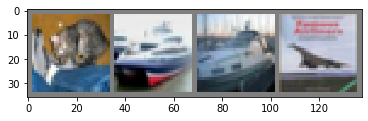

In [0]:
# 5. 테스트 집합을 이용하여 신경망 성능 확인
dataiter = iter(testloader)
images,labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 학습된 네트워크로 예측하기
#### 출력은 총 10개의 클래스
#### 가장 높은 예측값을 가진 클래스를 선택해 출력

In [0]:
outputs = net(images)
_, predicted = torch.max(outputs,1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship  ship


#### 전체 데이터셋에 대한 네트워크의 학습 정확도 출력

In [0]:
# performance on the whole test dataset
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" % (100*correct/total))

Accuracy of the network on the 10000 test images: 53 %


### (6) 화면 출력 확인 및 일반화 성능 서술
#### 53% 의 정확도가 나온것으로 보아하니, 총 10개의 클래스 중 한개를 선택하는 10% 보다는 확률이 높다. 따라서 네트워크가 무엇인가를 배웠다고 할 수 있다. 
#### 하지만 10개의 분류로 나누는데에 있어서 모델적인 한계가 있어 일반화를 시키기에는 성능이 떨어지는 모델이라고 볼 수 있다.
#### 의문점을 가지고 epoch 를 20으로 바꿔 학습을 시켜보았으나 정확도는 55%로 2% 정도 오르는 현상을 발견 했다.

In [0]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images,labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs,1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print("Accuracy of %5s : %2d %%" % (classes[i],100*class_correct[i]/class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 55 %
Accuracy of  bird : 36 %
Accuracy of   cat : 30 %
Accuracy of  deer : 54 %
Accuracy of   dog : 63 %
Accuracy of  frog : 46 %
Accuracy of horse : 63 %
Accuracy of  ship : 58 %
Accuracy of truck : 68 %


## (7) 화면 출력 확인 및 부류별 분류기의 성능 서술
##### 대체적으로 서로 비슷한 특징을 가지고 있는 bird, cat, deer의 일반화 성능이 제일 좋지 못하고, plane, ship 같은 특징이 명확한 사진 같은 경우는 일반화 성능이 괜찮게 나오는것을 확인할 수 있다.

# 4. 컨볼루션 층의 입력 크기가 32x32x3 이고, 
##(a) 10개 5x5 필터들을 보폭 1과 덧대기 2로 적용하였을 때, 출력의 크기와 매개 변수의 수를 구하세요. 
### -> 5x5 filter의 depth는 입력의 depth와 동일하게 설정이 된다. 따라서 10개의 5x5x3 filter 10개를 보폭 1로 적용하였을 때, 30x30 이 되는데 여기서 2로 padding 작업을 해줘서 32x32 로 유지가 된다. 그래서 출력의 크기는 32x32x10 이다. 매개변수의 수는 5x5x10 이 된다.

##(b) 동일한 입력에 64개 3*3 필터들을 보폭 1과 덧대기 1로 적용하였을 때 출력의 크기와 매개변수의 수도 구하세요.
### -> 3x3 filter를 보폭 1과 덧대기 1로 적용할 때는 출력의 사이즈는 입력의 사이즈와 동일하다. 따라서 출력의 크기는 32x32x64 이고, 매개변수의 수는 3x3x64 개가 된다.

# 5. 다음 조건을 만조가는 컨볼류션 신경망을 구현하고, 3번의 (3),(6),(7)의 성능 결과를 확인하고 비교하세요.
### (1) INPUT-CONV(32 3X3) - CONV(32 3X3) - RELU-POOL-CONV(32 3X3) - CONV(32 3X3) - RELU - POOL - FC - OUTPUT 

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    # 신경망 정의
    # input : 3 output : 32 kernel : 3x3
    self.conv1 = nn.Conv2d(3,32,3)
    # input : 32 output : 32 kernel : 3x3
    self.conv2 = nn.Conv2d(32,32,3)
    # input : 3 output : 32 kernel : 3x3
    self.conv3 = nn.Conv2d(32,32,3)
    # input : 3 output : 32 kernel : 3x3
    self.conv4 = nn.Conv2d(32,32,3)
    self.pool = nn.MaxPool2d(2,2)
    # input : 32x5x5 output : 10
    self.fc1 = nn.Linear(32*5*5,10)

  def forward(self,x):
    # 신경망 구성
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pool(F.relu(x))
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.pool(F.relu(x))
    x = x.view(-1,32*5*5)
    x = self.fc1(x)
    return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#훈련 집합을 이용하여 신경망을 학습시킴
for epoch in range(2): #loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0

print("Finished Training")

correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

  # performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))
    
    


[1,  2000] loss: 1.980
[1,  4000] loss: 1.559
[1,  6000] loss: 1.440
[1,  8000] loss: 1.340
[1, 10000] loss: 1.267
[1, 12000] loss: 1.191
[2,  2000] loss: 1.124
[2,  4000] loss: 1.106
[2,  6000] loss: 1.088
[2,  8000] loss: 1.067
[2, 10000] loss: 1.047
[2, 12000] loss: 1.050
Finished Training
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 74 %
Accuracy of   car : 76 %
Accuracy of  bird : 44 %
Accuracy of   cat : 55 %
Accuracy of  deer : 64 %
Accuracy of   dog : 61 %
Accuracy of  frog : 66 %
Accuracy of horse : 66 %
Accuracy of  ship : 68 %
Accuracy of truck : 79 %


### (1-분석) 3번과 다른 신경망을 구축하여 학습을 시킨 결과 65% 의 정확도을 얻게 되었다. 이는 이전 신경망의  정확도보다 대략 8~10% 높아진 결과로 봤을때 이 분류기에 조금 더 최적화된 네트워크라고 할 수 있겠다.

### (2) 3번 문제의 신경망에 Adam 최적화 ( 강의자료의 기본 hyper-parameters 사용 ) 적용

In [0]:
#5-2번
#3번의 3에 해당
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # input : 3 output : 6 kernel : 5x5
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2)
    # input : 6 output : 16 kernel : 5x5
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # input : 16x5x5 output : 120
    self.fc1 = nn.Linear(16*5*5, 120)
    # input : 120 output : 84
    self.fc2 = nn.Linear(120, 84)
    # input : 84 output : 10
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Pooling
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): #loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0

print("Finished Training")


correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


  # performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

[1,  2000] loss: 1.864
[1,  4000] loss: 1.612
[1,  6000] loss: 1.530
[1,  8000] loss: 1.468
[1, 10000] loss: 1.422
[1, 12000] loss: 1.397
[2,  2000] loss: 1.326
[2,  4000] loss: 1.293
[2,  6000] loss: 1.320
[2,  8000] loss: 1.287
[2, 10000] loss: 1.287
[2, 12000] loss: 1.294
Finished Training
Accuracy of the network on the 10000 test images: 53 %
Accuracy of plane : 39 %
Accuracy of   car : 62 %
Accuracy of  bird : 22 %
Accuracy of   cat : 50 %
Accuracy of  deer : 50 %
Accuracy of   dog : 33 %
Accuracy of  frog : 70 %
Accuracy of horse : 58 %
Accuracy of  ship : 79 %
Accuracy of truck : 64 %


###(2-분석) SGD 방식에서 Adam 방식으로 최적화 방법을 바꾼 결과를 봤을때 단순 정확도만 봤을때는 거의 차의가 없는 것으로 보인다. 따라서 신경망 모델의 구조가 달라지지 않는 이상, 최적화 방법은 큰 영향을 끼치지 않는것으로 보인다.

### (3) 데이터 확대 방법들 중 하나를 적용한 후, 3번 문제의 신경망 학습 (Hint : transforms)

In [0]:
#5-3
# Data transform
transform_3 = transforms.Compose([transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_3 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_3)
test_dataset_3 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_3)

trainloader_3 = torch.utils.data.DataLoader(train_dataset_3, batch_size = 4, shuffle = True, num_workers = 2)
testloader_3 = torch.utils.data.DataLoader(test_dataset_3, batch_size = 4, shuffle = False, num_workers = 2)

net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2): #loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader_3, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0

print("Finished Training")


correct = 0
total = 0
with torch.no_grad():
  for data in testloader_3:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

  # performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader_3:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.266
[1,  4000] loss: 1.951
[1,  6000] loss: 1.742
[1,  8000] loss: 1.649
[1, 10000] loss: 1.571
[1, 12000] loss: 1.512
[2,  2000] loss: 1.451
[2,  4000] loss: 1.424
[2,  6000] loss: 1.382
[2,  8000] loss: 1.343
[2, 10000] loss: 1.335
[2, 12000] loss: 1.318
Finished Training
Accuracy of the network on the 10000 test images: 52 %
Accuracy of plane : 69 %
Accuracy of   car : 80 %
Accuracy of  bird : 27 %
Accuracy of   cat : 19 %
Accuracy of  deer : 53 %
Accuracy of   dog : 38 %
Accuracy of  frog : 70 %
Accuracy of horse : 54 %
Accuracy of  ship : 58 %
Accuracy of truck : 54 %


### (3 - 분석) 데이터 transform 을 진행한 후 학습을 하였으나 5-2 의 accuracy 와 비교 했을때 1% 정도 떨어짐을 볼 수 있었다. 제한된 모델로는 한계가 있는것으로 보인다.

### (4) 3번 문제의 신경망에 CONV 층마다 배치 정규화를 적용 (HINT : nn.BatchNorm)

In [0]:
#5-4번
class Net_4(nn.Module):
  def __init__(self):
    super(Net_4, self).__init__()
    # input : 3 output : 6 kernel : 5x5
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    # input : 6 output : 16 kernel : 5x5
    self.conv2 = nn.Conv2d(6, 16, 5)
    # input : 16x5x5 output : 120
    self.fc1 = nn.Linear(16*5*5, 120)
    # input : 120 output : 84
    self.fc2 = nn.Linear(120, 84)
    # input 84 output : 10
    self.fc3 = nn.Linear(84, 10)
    
    # BatchNorm 사용
    self.layer1 = nn.Sequential(self.conv1,
                                nn.BatchNorm2d(6),
                                nn.ReLU(),
                                self.pool)
     # BatchNorm 사용
    self.layer2 = nn.Sequential(self.conv2,
                                nn.BatchNorm2d(16),
                                nn.ReLU(),
                                self.pool)
  
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net_4 = Net_4()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_4.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2): #loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    outputs = net_4(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0

print("Finished Training")


correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net_4(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


  # performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net_4(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

[1,  2000] loss: 1.975
[1,  4000] loss: 1.708
[1,  6000] loss: 1.588
[1,  8000] loss: 1.537
[1, 10000] loss: 1.504
[1, 12000] loss: 1.455
[2,  2000] loss: 1.386
[2,  4000] loss: 1.378
[2,  6000] loss: 1.354
[2,  8000] loss: 1.349
[2, 10000] loss: 1.302
[2, 12000] loss: 1.291
Finished Training
Accuracy of the network on the 10000 test images: 54 %
Accuracy of plane : 60 %
Accuracy of   car : 75 %
Accuracy of  bird : 34 %
Accuracy of   cat : 18 %
Accuracy of  deer : 50 %
Accuracy of   dog : 60 %
Accuracy of  frog : 67 %
Accuracy of horse : 60 %
Accuracy of  ship : 68 %
Accuracy of truck : 48 %


### (4-분석) 각 convolution 층 마다 batchnormalize 를 해줬으나 정확도에서는 크게 변동된 부분이 없다. 살짝 좋아진 부분은 있으나 큰 변동은 없는 것으로 보아 다른 규제 기법을 좀 더 찾아보는게 좋을듯 하다.
### 학습을 새로 돌릴때마다 정확도가 좋아질때가 있고, 나빠질때도 있다. 

### (5) 3번 문제의 신경망에 로그우도 손실함수를 적용

In [0]:
#5-5번

net = Net()

import torch.optim as optim

# log 우도 손실함수 적용
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2): #loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    outputs = net(inputs)
    outputs = nn.LogSoftmax(dim=1)(outputs) 
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0

print("Finished Training")

correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

  # performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

[1,  2000] loss: 2.179
[1,  4000] loss: 1.853
[1,  6000] loss: 1.680
[1,  8000] loss: 1.606
[1, 10000] loss: 1.516
[1, 12000] loss: 1.449
[2,  2000] loss: 1.417
[2,  4000] loss: 1.366
[2,  6000] loss: 1.347
[2,  8000] loss: 1.343
[2, 10000] loss: 1.313
[2, 12000] loss: 1.289
Finished Training
Accuracy of the network on the 10000 test images: 53 %
Accuracy of plane : 58 %
Accuracy of   car : 61 %
Accuracy of  bird : 25 %
Accuracy of   cat : 17 %
Accuracy of  deer : 35 %
Accuracy of   dog : 64 %
Accuracy of  frog : 76 %
Accuracy of horse : 59 %
Accuracy of  ship : 61 %
Accuracy of truck : 76 %


### (5 - 분석) 로그 우도 손실함수를 사용 함으로써 underfitting 을 줄일 수 있으나 정확도 면에서는 생각보다 많은 부분이 변동되지 않았다.

###(6) 3번 문제의 신경망에 L2놈 규제 적용

In [0]:
#5-6번
import torch.nn as nn
import torch.nn.functional as F

class Net_6(nn.Module):
  def __init__(self):
    super(Net_6, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(F.normalize(self.conv1(x), p = 2, eps=1e-12)))
    x = self.pool(F.relu(F.normalize(self.conv2(x), p = 2, eps=1e-12)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    

net_6 = Net_6()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# weight decay = 0.01 를 써서 L2 Norm 적용
optimizer = optim.SGD(net_6.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.01)

for epoch in range(2): #loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize
    outputs = net_6(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0

print("Finished Training")


correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net_6(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


  # performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net_6(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

[1,  2000] loss: 2.158
[1,  4000] loss: 1.911
[1,  6000] loss: 1.803
[1,  8000] loss: 1.721
[1, 10000] loss: 1.668
[1, 12000] loss: 1.598
[2,  2000] loss: 1.572
[2,  4000] loss: 1.554
[2,  6000] loss: 1.549
[2,  8000] loss: 1.516
[2, 10000] loss: 1.501
[2, 12000] loss: 1.488
Finished Training
Accuracy of the network on the 10000 test images: 41 %
Accuracy of plane : 55 %
Accuracy of   car :  5 %
Accuracy of  bird : 18 %
Accuracy of   cat : 34 %
Accuracy of  deer : 27 %
Accuracy of   dog : 47 %
Accuracy of  frog : 35 %
Accuracy of horse : 75 %
Accuracy of  ship : 34 %
Accuracy of truck : 79 %


###(6-분석) L2 norm 가중치 규제를 통하여 모델을 좀 더 general 하게 만들어줬지만, 정확도가 41% 까지 떨어지는 현상을 발견했다. 따라서 규제를 잘 이해하지 못하고 사용하는 경우 정확도에서 큰 손실을 볼 수 있을것 같다.

# 5. 신경망의 출력이 (0.4, 2.0, 0.001, 0.32)T 일때 소프트맥스 함수를 적용한 결과를 쓰시오.

In [0]:
import torch

x = torch.Tensor([0.4,2.0,0.001,0.32])
x = torch.t(x)

m = torch.nn.Softmax()
x = m(x)

print("result : ", x)

result :  tensor([0.1325, 0.6563, 0.0889, 0.1223])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


# 6. 소프트맥스 함수를 적용한 후 출력이 (0.001,0.9, 0.001, 0.098)T이고 레이블 정보가 (0,0,0,1)T 일 때, 세 가지 목적함수, 평균 제곱 오차, 교차 엔트로피, 로그우도를 계산하시오.

In [0]:
output = torch.tensor([0.001, 0.9, 0.001, 0.098])
label = torch.tensor([0,0,0,1.0])

# 평균 제곱 오차
mse = nn.MSELoss()
mse_loss = mse(output,label)
print("Result of MSE : ", mse_loss)

# 교차 엔트로피
cross_entropy_loss = -1*(label*(output.log2())).sum()
print("Result of Cross Entropy Loss : ", cross_entropy_loss)

# 로그우도
log_likelihood_loss = (label*output).sum().log2()*-1
print("Result of Log Likeli Hood Loss : ", log_likelihood_loss)

Result of MSE :  tensor(0.4059)
Result of Cross Entropy Loss :  tensor(3.3511)
Result of Log Likeli Hood Loss :  tensor(3.3511)
